# BlueCruise Risk Model: Near Miss Algorithm Development V3

### Approach:
- Use Developed Near Miss Algorithm to calculate distance profiles

In [8]:
# Imports
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import near_miss_algorithms.near_miss_v3 as nma


# Load Datasets

### BlueCruise Second by second dataset 

In [2]:
df_bc = pd.read_csv('data/bc_claims_labelled_veh_dyn.csv')

In [3]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571110 entries, 0 to 5571109
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   trip_num                   int64  
 1   date_time                  object 
 2   veh_long_vel_mps           float64
 3   veh_ltrl_vel_mps           float64
 4   veh_yaw_rate_radps         float64
 5   veh_accel_mps2_analytical  float64
 6   veh_jerk_mps3_analytical   float64
 7   impact_indicator           int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 340.0+ MB


### Impact Sequence dataset

In [4]:
windows_df = pd.read_csv('data/bc_impact_sequences1.csv')

In [5]:
windows_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trip_num                   346 non-null    int64  
 1   date_time                  346 non-null    object 
 2   veh_long_vel_mps           346 non-null    float64
 3   veh_ltrl_vel_mps           346 non-null    float64
 4   veh_yaw_rate_radps         346 non-null    float64
 5   veh_accel_mps2_analytical  346 non-null    float64
 6   veh_jerk_mps3_analytical   346 non-null    float64
 7   seg_num_id                 346 non-null    int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 21.8+ KB


# Data Preprocessing

In [9]:
## Trip Duration Dataframe

# Convert the date_time column to datetime format
df_bc['date_time'] = pd.to_datetime(df_bc['date_time'], format='ISO8601')

# Find the start and end time of each trip and the duration of each trip
start_time = df_bc.groupby('trip_num')['date_time'].first()
end_time = df_bc.groupby('trip_num')['date_time'].last()
trip_duration = end_time - start_time

# Create a new dataframe with the trip number, start time, end time, and duration
trip_info = pd.DataFrame({'start_time': start_time, 'end_time': end_time, 'duration': trip_duration})
trip_info.reset_index(inplace=True)
# sort the dataframe by longest trip first
trip_info.sort_values('duration', ascending=False, inplace=True)

In [10]:
# Remove all trips from df_bc that have a trip length less than 12 seconds using the trip_info DataFrame
valid_trip_nums = trip_info[trip_info['duration'] >= pd.Timedelta(seconds=12)]['trip_num'].unique()
df_bc_filtered = df_bc[df_bc['trip_num'].isin(valid_trip_nums)]

In [11]:
# Create a DataFrame to show the lengths of each query
query_lengths = windows_df.groupby('seg_num_id').size().reset_index(name='length')

# Remove queries that are shorter than the minimum query length allowed = 5
min_query_length = 5
windows_df_filtered = windows_df[windows_df['seg_num_id'].isin(query_lengths[query_lengths['length'] >= min_query_length]['seg_num_id'])]

In [12]:
# The best queries from each impact trip based on the average minimum Euclidean distance
selected_query_num = [7, 13, 21, 22, 34]

# Create a DataFrame to hold the selected queries
windows_df_filtered = windows_df_filtered[windows_df_filtered['seg_num_id'].isin(selected_query_num)]

In [13]:
# Find unique seg_num_ids in windows_df
seg_num_ids = windows_df_filtered['seg_num_id'].unique()
print(f"Number of unique seg_num_ids: {len(seg_num_ids)}")

Number of unique seg_num_ids: 5


In [14]:
# Save the filtered DataFrame to a CSV file
windows_df_filtered.to_csv('data/windows_df_nm_filtered.csv', index=False)

# Save the df_bc_filtered DataFrame to a CSV file
df_bc_filtered.to_csv('data/df_bc_nm_filtered.csv', index=False)

# Sequence Identification Functions
- Utilitizing Developed Near Miss Algorithm

In [2]:
# Function to calculate the combined distance profile
def compute_combined_distance(query_df, trip_df, columns):
    combined_distance_profile = nma.near_miss(trip_df[columns[0]].values, query_df[columns[0]].values)  # Initialize combined distance profile

    # Loop through each column and compute the distance profile
    for col in columns:
        if col == columns[0]:
            continue
        distance_profile = nma.near_miss(trip_df[col].values, query_df[col].values)
        combined_distance_profile += distance_profile  # Sum the distance profiles

    return combined_distance_profile

In [3]:
# Function to compute MASS for a single trip-query pair
def compute_mass_for_trip(query_df, trip_df, query_num, trip_num, time_series_columns):
    query_length = len(query_df)
    trip_length = len(trip_df)

    # Skip if the trip is shorter than the query
    if trip_length < query_length:
        return None

    # Compute the combined distance profile
    combined_distance_profile = compute_combined_distance(query_df, trip_df, time_series_columns)

    # Remove nan values in the distance profile
    # Remove trailing NaN values from the combined distance profile
    first_nan_index = np.where(np.isnan(combined_distance_profile))[0][0] if np.any(np.isnan(combined_distance_profile)) else len(combined_distance_profile)
    combined_distance_profile = combined_distance_profile[:first_nan_index]

    # Compute the minimum  distance
    min_distance = np.min(combined_distance_profile)

    # Return the result as a dictionary
    return {
        'trip_num': trip_num,
        'query_num': query_num,
        'distance_profile': combined_distance_profile,
        'min_distance': min_distance
    }

In [4]:
# Optimized function to get distance profiles for all trips in parallel
def get_distance_profiles_parallel(windows_df, df_bc, time_series_columns, n_jobs=-1):
    results = []  # List to accumulate results

    # Loop over each query
    for query_num in windows_df['seg_num_id'].unique():
        query_df = windows_df[windows_df['seg_num_id'] == query_num].copy()
        query_trip_num = query_df['trip_num'].values[0]

        # Use Parallel to process each trip in parallel
        trip_results = Parallel(n_jobs=n_jobs)(
            delayed(compute_mass_for_trip)(query_df, df_bc[df_bc['trip_num'] == trip_num].copy(), query_num, trip_num, time_series_columns)
            for trip_num in df_bc['trip_num'].unique()
            if trip_num != query_trip_num  # Skip the query's own trip
        )

        # Filter out None results (trips that were skipped)
        trip_results = [result for result in trip_results if result is not None]

        # Append the valid results to the main results list
        results.extend(trip_results)

    # Convert accumulated results into a DataFrame
    distance_profiles_dict = results

    return distance_profiles_dict

# Find Near Misses using Distance Profiles

In [5]:
df_bc_filtered = pd.read_csv('data/df_bc_nm_filtered.csv')  # Load the filtered DataFrame
windows_df_filtered = pd.read_csv('data/windows_df_nm_filtered.csv')  # Load the filtered DataFrame

In [6]:
# The initial columns to compare in the time series data
time_series_columns = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_jerk_mps3_analytical']

In [9]:
start_time = time.time()

distance_profiles = get_distance_profiles_parallel(windows_df_filtered, df_bc_filtered, time_series_columns)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Save the distance profiles dictionary to a file
with open('data/near_missv3_distance_profiles_dict.pkl', 'wb') as f:
    pickle.dump(distance_profiles, f)

Execution time: 5303.12 seconds


In [10]:
# Display the first distance profile
distance_profiles[254]

{'trip_num': 261,
 'query_num': 7,
 'distance_profile': array([2.12443134]),
 'min_distance': 2.1244313375019854}

### Start work on distance profiles here

In [26]:
# Load the distance profiles dictionary from a file
with open('data/near_missv3_distance_profiles_dict.pkl', 'rb') as f:
    distance_profiles = pickle.load(f)

In [27]:
# Create a DataFrame to hold the all the same information except the distance profile
distance_profiles_df = pd.DataFrame({
    'trip_num': [result['trip_num'] for result in distance_profiles],
    'query_num': [result['query_num'] for result in distance_profiles],
    'min_distance': [result['min_distance'] for result in distance_profiles]
})

In [28]:
distance_profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32890 entries, 0 to 32889
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trip_num      32890 non-null  int64  
 1   query_num     32890 non-null  int64  
 2   min_distance  32890 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 771.0 KB


In [13]:
# Save the distance profiles DataFrame to a file
distance_profiles_df.to_csv('data/near_missv3_distance_profiles_df.csv', index=False)

In [ ]:
#Load distance pr

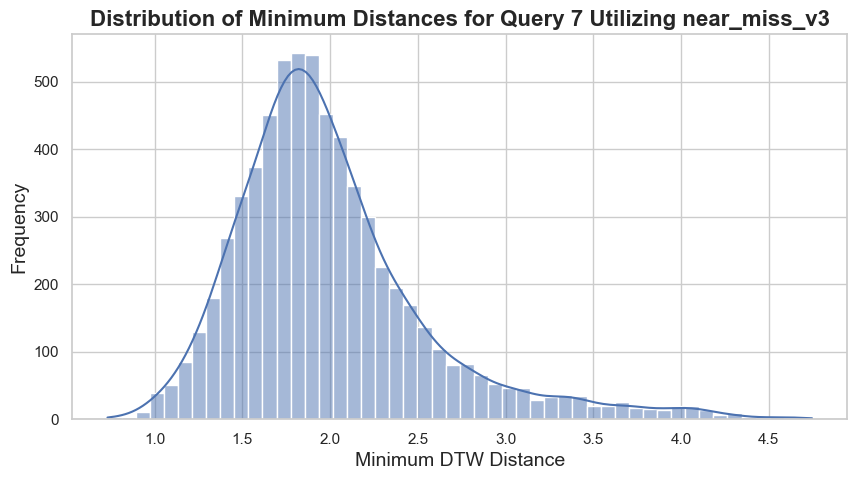

In [29]:
# Lets look at the distribution for a given query
query_num = 7

# Filter the distance profiles for the given query in the distance_profiles dicitionary
distance_profiles_query = distance_profiles_df[distance_profiles_df['query_num'] == query_num]

# Sort the distance profiles for the given query
distance_profiles_query_sorted = distance_profiles_query.sort_values('min_distance')

# Plot a histogram of the minimum Euclidean distances for the given query
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))
sns.histplot(distance_profiles_query_sorted['min_distance'], bins=50, kde=True)
plt.title(f'Distribution of Minimum Distances for Query {query_num} Utilizing near_miss_v3', fontsize=16, fontweight='bold')
plt.xlabel('Minimum DTW Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
# plt.xlim(0, 25)  # Set x-axis range between 0 and 25
plt.show()

In [30]:
# The best queries from each impact trip based on the average minimum Euclidean distance
selected_query_num = [7, 13, 21, 22, 34]

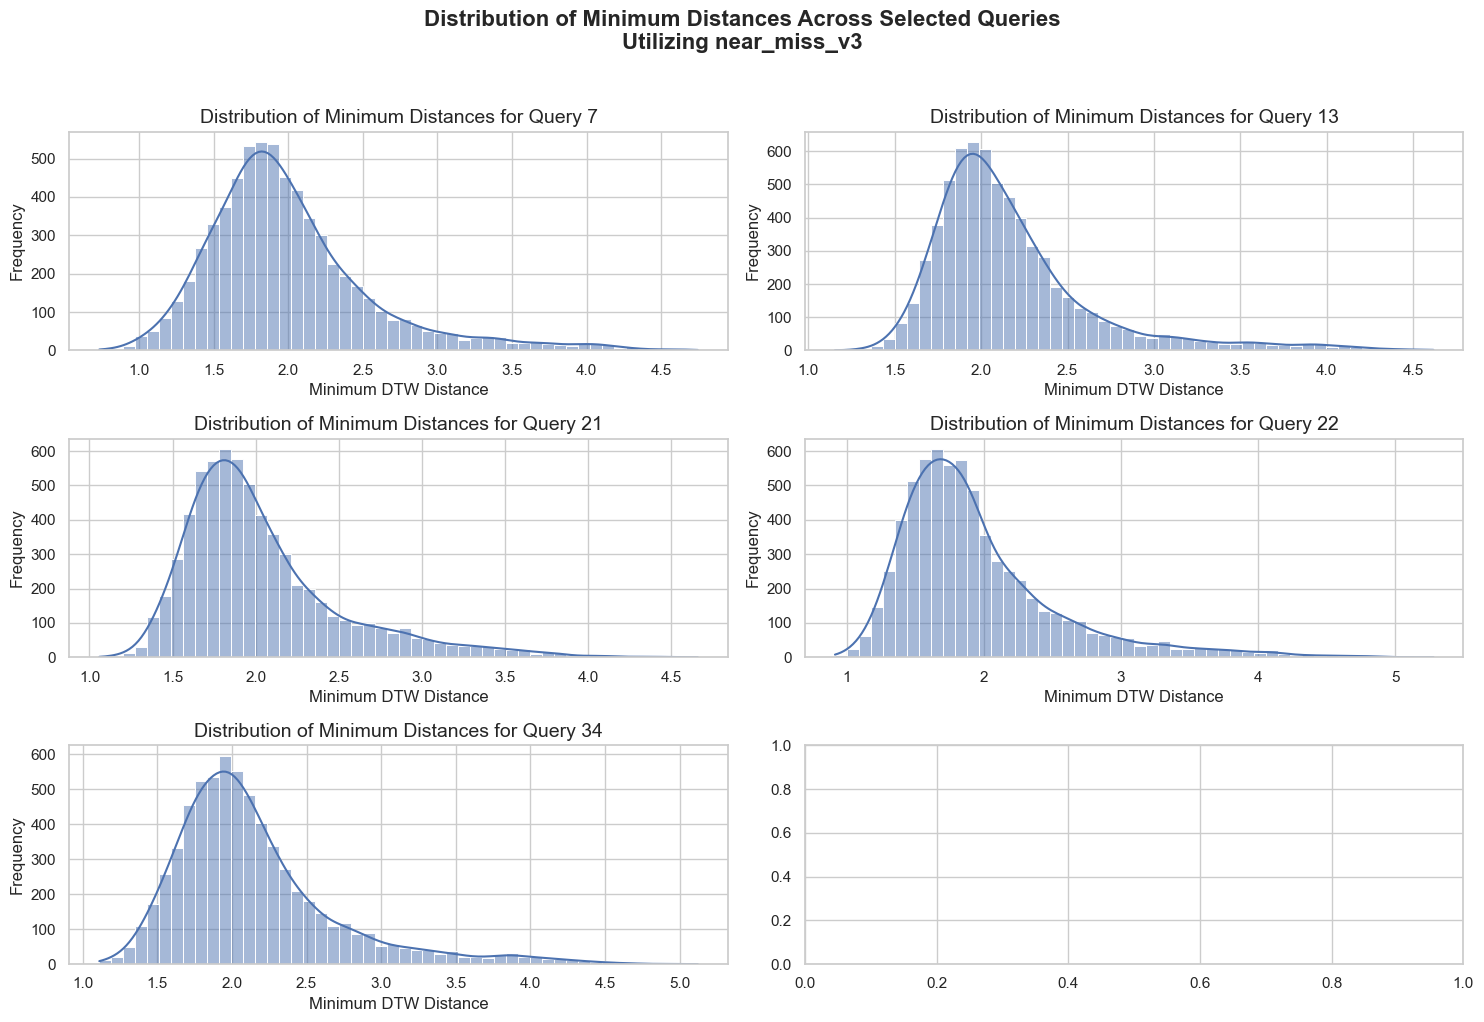

In [31]:
# Plot a grid of all the 5 distance profiles for the selected queries
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Add overall title
fig.suptitle('Distribution of Minimum Distances Across Selected Queries\nUtilizing near_miss_v3', fontsize=16, fontweight='bold', y=1.02)

for i, query_num in enumerate(selected_query_num):
    distance_profiles_query = distance_profiles_df[distance_profiles_df['query_num'] == query_num]
    sns.histplot(distance_profiles_query['min_distance'], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Minimum Distances for Query {query_num}', fontsize=14)
    axes[i].set_xlabel('Minimum DTW Distance', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(True)
    # axes[i].set_xlim(0, 25)  # Set x-axis range between 0 and 25
plt.tight_layout()

# Show the plots
plt.show()

# Lets test this algorithm with the Scale penalty now

#### Scale Penalty = 0.3

In [18]:
# Function to calculate the combined distance profile
def compute_combined_distance(query_df, trip_df, columns):
    combined_distance_profile = nma.near_miss(trip_df[columns[0]].values, query_df[columns[0]].values, scale_weight=0.1)  # Initialize combined distance profile

    # Loop through each column and compute the distance profile
    for col in columns:
        if col == columns[0]:
            continue
        distance_profile = nma.near_miss(trip_df[col].values, query_df[col].values, scale_weight=0.1)
        combined_distance_profile += distance_profile  # Sum the distance profiles

    return combined_distance_profile

In [19]:
start_time = time.time()

distance_profiles = get_distance_profiles_parallel(windows_df_filtered, df_bc_filtered, time_series_columns)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Save the distance profiles dictionary to a file
with open('data/near_missv3_scale_penalty_distance_profiles_dict.pkl', 'wb') as f:
    pickle.dump(distance_profiles, f)

Execution time: 3200.21 seconds


In [32]:
# Load the distance profiles dictionary from a file
with open('data/near_missv3_scale_penalty_distance_profiles_dict.pkl', 'rb') as f:
    distance_profiles = pickle.load(f)

In [33]:
# Create a DataFrame to hold the all the same information except the distance profile
distance_profiles_df = pd.DataFrame({
    'trip_num': [result['trip_num'] for result in distance_profiles],
    'query_num': [result['query_num'] for result in distance_profiles],
    'min_distance': [result['min_distance'] for result in distance_profiles]
})

In [21]:
distance_profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32890 entries, 0 to 32889
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trip_num      32890 non-null  int64  
 1   query_num     32890 non-null  int64  
 2   min_distance  32890 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 771.0 KB


In [22]:
# Save the distance profiles DataFrame to a file
distance_profiles_df.to_csv('data/near_missv3_scale_penalty_distance_profiles_df.csv', index=False)

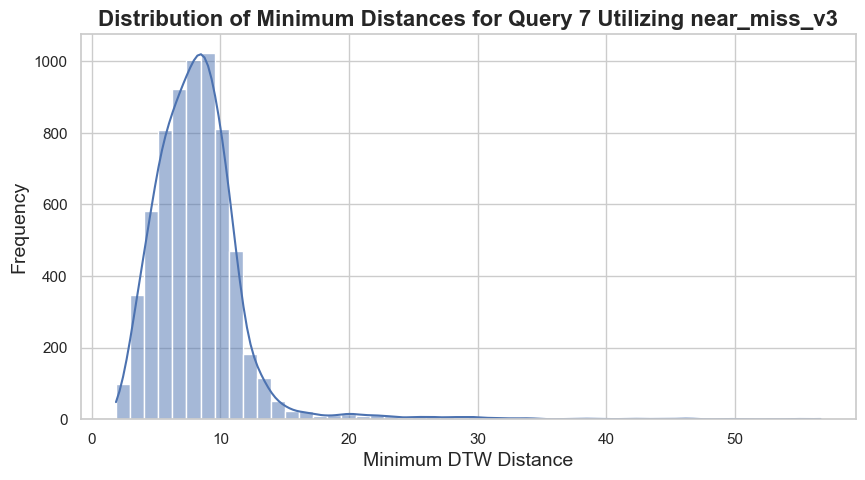

In [34]:
# Lets look at the distribution for a given query
query_num = 7

# Filter the distance profiles for the given query in the distance_profiles dicitionary
distance_profiles_query = distance_profiles_df[distance_profiles_df['query_num'] == query_num]

# Sort the distance profiles for the given query
distance_profiles_query_sorted = distance_profiles_query.sort_values('min_distance')

# Plot a histogram of the minimum DTW distances for the given query
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))
sns.histplot(distance_profiles_query_sorted['min_distance'], bins=50, kde=True)
plt.title(f'Distribution of Minimum Distances for Query {query_num} Utilizing near_miss_v3', fontsize=16, fontweight='bold')
plt.xlabel('Minimum DTW Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
# plt.xlim(0, 25)  # Set x-axis range between 0 and 25
plt.show()

In [24]:
# The best queries from each impact trip based on the average minimum Euclidean distance
selected_query_num = [7, 13, 21, 22, 34]

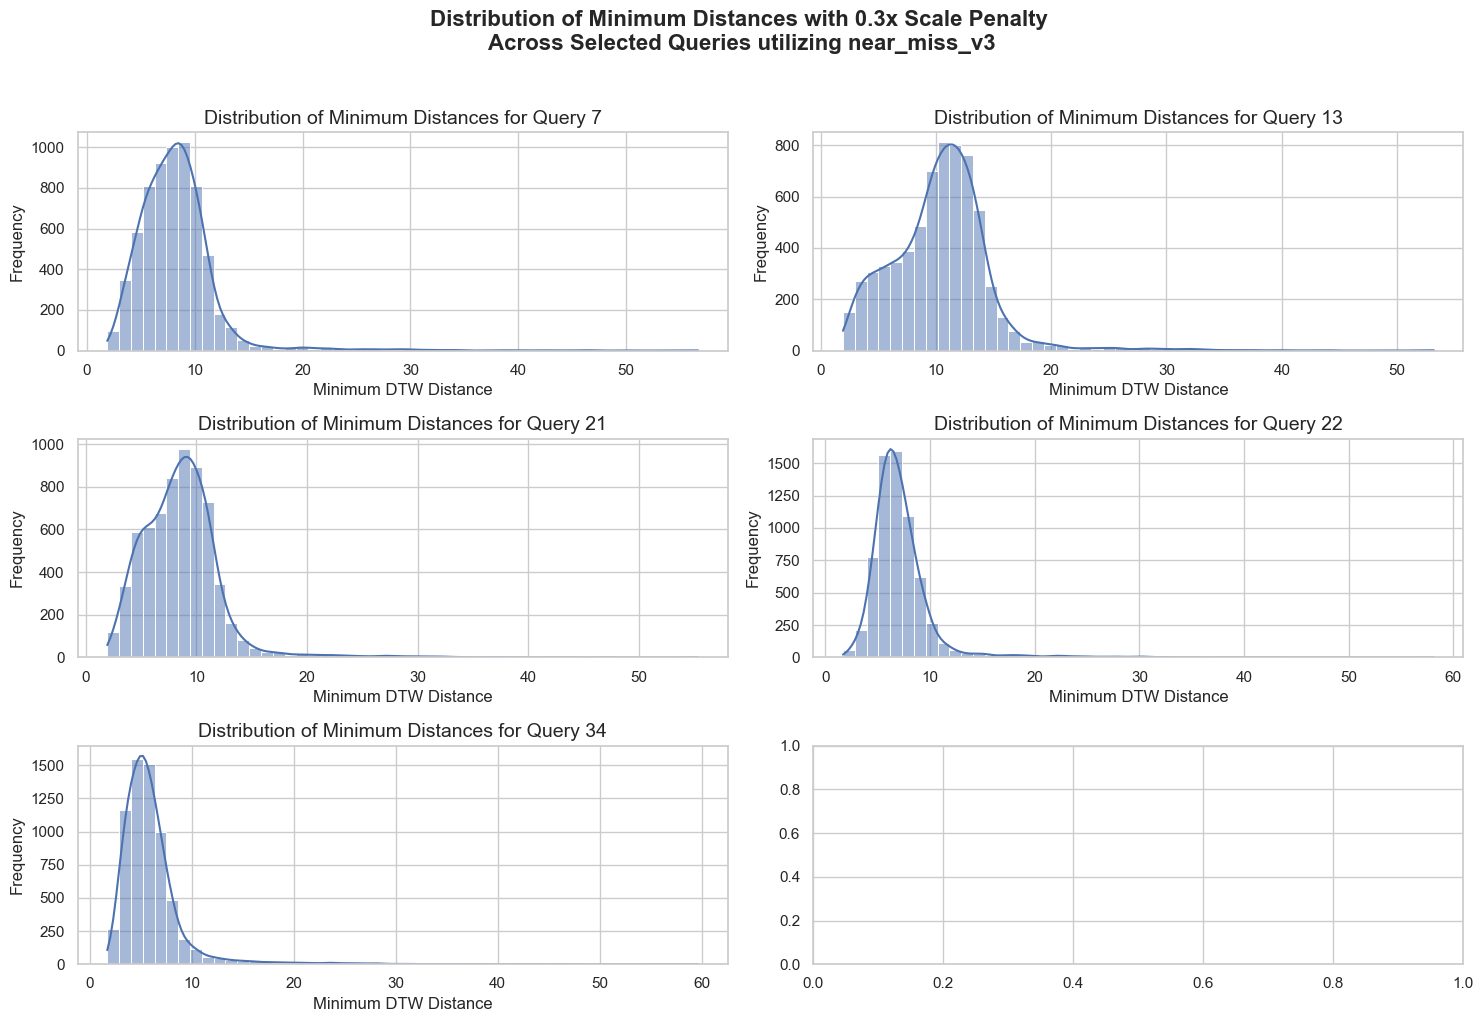

In [37]:
# Plot a grid of all the 5 distance profiles for the selected queries
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()
# Add overall title
fig.suptitle('Distribution of Minimum Distances with 0.3x Scale Penalty \nAcross Selected Queries utilizing near_miss_v3', fontsize=16, fontweight='bold', y=1.02)
for i, query_num in enumerate(selected_query_num):
    distance_profiles_query = distance_profiles_df[distance_profiles_df['query_num'] == query_num]
    sns.histplot(distance_profiles_query['min_distance'], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of Minimum Distances for Query {query_num}', fontsize=14)
    axes[i].set_xlabel('Minimum DTW Distance', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(True)
    # axes[i].set_xlim(0, 25)  # Set x-axis range between 0 and 25
plt.tight_layout()

# Show the plots
plt.show()